<a href="https://colab.research.google.com/github/aquibjaved/Deep-learning-for-text-classification/blob/master/RNN/simple_RNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
from gensim import models
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 6.4MB/s 


In [0]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '19vFHpNAuEUZIbOYrlXDRWJPOoXLMv3bX'
downloaded = drive.CreateFile({'id': file_id})

download = drive.CreateFile({'id': file_id})
download.GetContentFile('DOWNLOAD.tar')

# print('Downloaded content "{}"'.format(downloaded.GetContentString()))

In [10]:
!pwd

/content


In [12]:
embeddings_index = {}
f = open('../content/Deep_learning_for_text_classification/embeddings/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [13]:
from numpy import zeros
import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers.embeddings import Embedding

Using TensorFlow backend.


In [0]:
# Reading data
train_df = pd.read_csv('../content/Deep_learning_for_text_classification/Data/imdb_master.csv', encoding = "ISO-8859-1")

In [0]:
train_df = train_df.drop(["Unnamed: 0","file", "type"], axis=1)
train_df = train_df[train_df.label != 'unsup']
train_df["label"] = train_df["label"].map({"pos":1,"neg":0})

In [0]:
# Cleaning and Pre Processing text
import re

def clean_numbers(text):
    text = re.sub('[0-9]{5,}', '#####', text)
    text = re.sub('[0-9]{4}', '####', text)
    text = re.sub('[0-9]{3}', '###', text)
    text = re.sub('[0-9]{2}', '##', text)
    return text

def clean_text(text):
    text = clean_numbers(text)
    text = str(text)

    for punct in "/-'":
        text = text.replace(punct, ' ')
    for punct in '&':
        text = text.replace(punct, f' {punct} ')
    for punct in '?!.,"$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        text = text.replace(punct, '')

    text = text.lower()
    return text

In [18]:
# Clean text in dataFrame
train_df["processed_data"] = train_df["review"].progress_apply(lambda x: clean_text(x))
train_df["length"] = train_df["processed_data"].progress_apply(lambda x: len(x.split()))

100%|██████████| 50000/50000 [00:00<00:00, 63585.32it/s]


In [0]:
docs = train_df["processed_data"].values
labels = train_df["label"].values

In [20]:
# Import gc, clearing some memory in ram
import gc
del train_df
gc.collect()

21

In [0]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1

In [0]:
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)

In [0]:
# pad documents to a max length of max words
max_length = 150
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [0]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 50))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [0]:
# Create Train/Test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    padded_docs, labels, test_size=0.2, random_state=42)

In [0]:
vocab_size = vocab_size

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 50, weights=[embedding_matrix], 
                                 input_length=max_length, trainable=False))

model.add(keras.layers.CuDNNLSTM((128),  return_sequences=True))
model.add(keras.layers.CuDNNLSTM((64),  return_sequences=False))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 150, 50)           7018250   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 150, 128)          92160     
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 64)                49664     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 7,160,139
Trainable params: 141,889
Non-trainable params: 7,018,250
_________________________________________________________________


In [36]:
history = model.fit(X_train,y_train, epochs=10, validation_data=(X_test,y_test), batch_size=256)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 12s 299us/step - loss: 0.3249 - acc: 0.8590 - val_loss: 0.3699 - val_acc: 0.8322
Epoch 2/10
40000/40000 [==============================] - 12s 297us/step - loss: 0.3232 - acc: 0.8588 - val_loss: 0.3349 - val_acc: 0.8563
Epoch 3/10
40000/40000 [==============================] - 12s 293us/step - loss: 0.3043 - acc: 0.8687 - val_loss: 0.3320 - val_acc: 0.8583
Epoch 4/10
40000/40000 [==============================] - 12s 293us/step - loss: 0.3131 - acc: 0.8632 - val_loss: 0.3638 - val_acc: 0.8377
Epoch 5/10
40000/40000 [==============================] - 12s 294us/step - loss: 0.2996 - acc: 0.8727 - val_loss: 0.3392 - val_acc: 0.8537
Epoch 6/10
40000/40000 [==============================] - 12s 298us/step - loss: 0.2796 - acc: 0.8791 - val_loss: 0.3334 - val_acc: 0.8611
Epoch 7/10
40000/40000 [==============================] - 12s 298us/step - loss: 0.2678 - acc: 0.8868 - val_loss: 0.

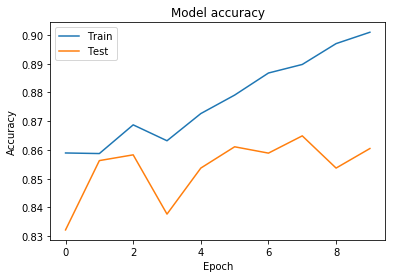

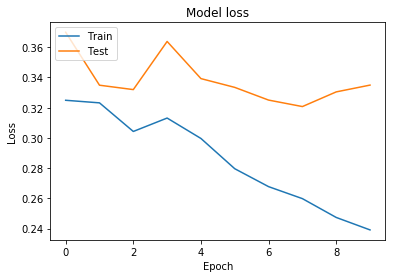

In [37]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()